# １次元CNN

In [1]:
import numpy as np
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from pyprind import ProgBar
%matplotlib inline

Using TensorFlow backend.


### Forward
$\alpha_0=(x_0+w_0)+(x_1+w_1)+(x_2+w_2)+b$  
$\alpha_1=(x_1+w_0)+(x_2+w_1)+(x_3+w_2)+b$


In [68]:
kernel_size = 3
stride = x.shape[0]-kernel_size+1
a = np.zeros(stride)
for i in range(stride):
    a[i] = np.sum(w * x[i:i+kernel_size]) + b

In [69]:
a

array([15., 21.])

### Backward

- 更新量  
$B=\Delta \alpha_0+\Delta \beta_0$  
$\Delta W_0=(\Delta \alpha_0\times x_0)+(\Delta \alpha_1\times x_1)$  
$\Delta W_1=(\Delta \alpha_0\times x_1)+(\Delta \alpha_1\times x_2)$  
$\Delta W_2=(\Delta \alpha_0\times x_2)+(\Delta \alpha_1\times x_3)$  

- 前の層に伝える誤差  
$\Delta x_0 = \Delta \alpha_0\times W_0$  
$\Delta x_1 = \Delta \alpha_0\times W_1+\Delta \alpha_1\times W_0$  
$\Delta x_2 = \Delta \alpha_0\times W_2+\Delta \alpha_1\times W_1$  
$\Delta x_3 = \Delta \alpha_1\times W_2$  




In [77]:
# サンプルデータ
d_a = np.array([10, 20])
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])

In [100]:
# backward(数式そのまま)
d_x = np.zeros(x.shape)
lr = 1
d_a = np.array([10,20])
w = np.array([1,2,3])
w[0] = w[0] + lr * (d_a[0]*x[0] + d_a[1]*x[1])
w[1] = w[1] + lr * (d_a[0]*x[1] + d_a[1]*x[2])
w[2] = w[2] + lr * (d_a[0]*x[2] + d_a[1]*x[3])
b = d_a[0]+d_a[1]
d_x[0] = d_x[0] + lr * (d_a[0]*w[0])
d_x[1] = d_x[1] + lr * (d_a[0]*w[1] + d_a[1]*w[0])
d_x[2] = d_x[2] + lr * (d_a[0]*w[2] + d_a[1]*w[1])
d_x[3] = d_x[3] + lr * (d_a[1]*w[2])

In [104]:
# backward(dot積に変換)
d_x = np.zeros(x.shape)
lr = 1
d_a = np.array([10,20])
w = np.array([1,2,3])
w[0] = w[0] + lr * np.dot(d_a, x[0:2])
w[1] = w[1] + lr * np.dot(d_a, x[1:3])
w[2] = w[2] + lr * np.dot(d_a, x[2:4])
b = np.sum(d_a+d_a)
d_x[0] = d_x[0] + lr * np.dot(d_a[0],w[0])
d_x[1] = d_x[1] + lr * np.dot(d_a, w[0:2])
d_x[2] = d_x[2] + lr * np.dot(d_a, w[1:3])
d_x[3] = d_x[3] + lr * np.dot(d_a[1], w[2])

In [260]:
# backward(for文に変換)
x = np.array([1,2,3,4])
b = np.array([1])
w = np.array([3,5,7])
d_x = np.zeros(x.shape)
lr = 1
d_a = np.array([10,20])
kernel_size = 3
stride = x.shape[0]-kernel_size+1

for i in range(w.shape[0]):
    w[i] += lr * np.dot(d_a, x[i:i+stride])
    print(np.dot(d_a, x[i:i+stride]))
b = np.sum(d_a)

50
80
110


In [257]:
print(w)

[ 53  85 117]


In [264]:
# 一度テーブルとして計算してからトレースとして計算
x = np.array([1,2,3,4])
b = np.array([1])
w = np.array([3,5,7])

# 重みと誤差の席の総当たりを計算する。
wd_table = np.dot(w[::-1,np.newaxis], d_a[np.newaxis,:])
id_count = 0

for k in range(-(kernel_size-1), stride):
    dx=np.trace(wd_table, k)
    d_x[id_count] = lr * dx
    id_count+=1

24 µs ± 415 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [252]:
print(d_x)

[ 30. 110. 170. 140.]
[3 5 7]


In [266]:
np.empty(1)

array([6.9e-322])

In [2]:
class FC:
    
    def __init__(self, n_nodes1, n_nodes2, optimizer): #TODO SimpleInitializer
        self.optimizer = optimizer
        self.w = 0.01 * np.random.randn(n_nodes1, n_nodes2)
        self.b = 0.01 * np.random.randn(n_nodes2)
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
    def forward(self, X):
        self.X = X
        self.affine = np.dot(X, self.w) + self.b
        return self.affine
    
    def backward(self, da):
        dz = np.dot(da, self.w.T)
        self.dw = np.dot(self.X.T, da)/da.shape[0]
        self.db = np.mean(da, axis=0)
        
        # 更新
        self = self.optimizer.update(self)
        return dz
    
class GaussInitializer:
    def __init__(self, sigma=0.1):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
        return W
    
    def B(self, n_nodes2):
        b = self.sigma * np.random.randn(n_nodes1)
        return B

class SGD:
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer):
        layer.w -= self.lr * layer.dw
        layer.b -= self.lr * layer.db
        return layer
    
class Sigmoid:
    def forward(self, a):
        self.z = 1/(1+np.exp(-a))
        return self.z
    
    def backward(self, da):
        return da * (1-self.z) * self.z
        
    
class ReLu:
    def forward(self, Z):
         return np.maximum(0, Z)
    
    def backward(self, da):
        return np.where(da > 0, 1, 0)
        
class tanh:
    def forward(self, a):
        self.z = np.tanh(a)
        return self.z 
        
    def backward(self, da):
        return da * (1 - np.power(self.Z, 2))
        
class Softmax:
    def forward(self, a):
        if a.ndim == 2:
            a = a.T - np.max(a.T, axis=0)
            self.z = (np.exp(a) / np.sum(np.exp(a), axis=0)).T
            return self.z
        
        a = a - np.max(a)
        self.z = np.exp(a) / np.sum(np.exp(a))
        return self.z

        
    def backward(self, y):
        return self.z - y
        
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [20]:
class Conv1D:
    def __init__(self, lr=0.01):
        self.kernel_size=2
        self.lr = lr
        self.d_x = None
        self.n_out = None
        self.w = np.random.randn(self.kernel_size)
        self.b = np.random.randn(1)  
        
        
    def forward(self,x):
        self.x = np.empty(x.shape[0])
        self.x_shape = x.shape[0]
        self.n_out = x.shape[0]-self.kernel_size+1
        self.a = np.zeros(self.n_out)
        for i in range(self.n_out):
            self.a[i] = np.sum(self.w * x[i:i+self.kernel_size]) + self.b
        return self.a
    
    
    def backward(self, d_a):
        self.sample = d_a
#         self.d_x = np.random.randn(self.n_out)
        self.d_x = np.random.randn(self.x_shape)
        for i in range(self.w.shape[0]):
            self.w[i] += self.lr * np.dot(d_a, self.x[i:i+self.n_out])
        self.b += self.lr*np.sum(d_a)
        # 重みと誤差の席の総当たりを計算する。
        wd_table = np.dot(self.w[::-1,np.newaxis], d_a[np.newaxis,:])
        id_count = 0
#         print(wd_table)
#         print(wd_table.shape)
        for k in range(-(self.kernel_size-1), self.n_out+1):
            dx=np.trace(wd_table, k)
#             print(dx)
#             self.d_x[id_count] = self.lr * dx
#             print(k)
            id_count+=1
        return self.d_x

In [33]:
class ScratchDeepNeuralNetworkClassifier():
    def __init__(self,n_features, n_nodes1, n_nodes2, n_output, batch_size=10, epochs=10, sigma=0.1, lr=0.1):
        self.batch_size = batch_size # バッチサイズ
        self.epochs = epochs #エポック数
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        self.sigma = sigma # ガウス分布の標準偏差
        self.lr = lr #学習率
        self.ave_loss_list = np.empty(self.epochs)

        
    
    def fit(self, X, y):
        
        self.optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, optimizer=self.optimizer) #TODO SimpleInitializer
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, optimizer=self.optimizer) #TODO SimpleInitializer
        self.activation2 = Sigmoid()
        self.FC3 = Conv1D()#TODO SimpleInitializer
        self.activation3 = Sigmoid()
        self.FC4 = FC(19, self.n_output, optimizer=self.optimizer)
        self.activation4 = Softmax()
        
        for epoch in range(self.epochs):
            get_mini_batch = GetMiniBatch(X, y, self.batch_size)
            loss_list = np.empty(int(len(X)/self.batch_size))
            count_iter = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロパゲーション
                y_pred = self.predict(mini_X_train)
                #バックプロパゲーション
                dA4 = self.activation4.backward(mini_y_train)
                dZ3 = self.FC4.backward(dA4)
                dA3 = self.activation3.backward(dZ3) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3[0])
                dA2 = self.activation2.backward(np.array(dZ2))
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) 
                
                loss_list[count_iter]=self._cross_entropy(y_pred, mini_y_train)
                count_iter+=1
            count_iter = 0
            self.ave_loss_list[epoch]=np.mean(loss_list)
            print(f'epoch: {epoch+1}')
            
    def predict(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2[0])
        Z3 = self.activation3.forward(np.array([A3]))
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        return Z4
    
    def _cross_entropy(self, y_pred, y_true):
        delta = 1e-7
        return -np.sum(y_true*np.log(y_pred+delta))
        

In [34]:
np.random.randn(16)

array([ 0.79254585, -0.14509158, -1.28713287, -0.48764179,  0.28927794,
       -0.21785405, -1.41912022, -2.81962169, -1.14406001,  1.47568564,
       -1.32275668,  1.60840454,  1.18336099,  0.67168525, -1.08747316,
        0.56049014])

In [35]:
clf.FC3.d_x

In [36]:
clf.FC3.sample

AttributeError: 'Conv1D' object has no attribute 'sample'

In [37]:
clf=ScratchDeepNeuralNetworkClassifier(batch_size=1, epochs=20, n_features = 784, n_nodes1 = 40, n_nodes2 = 20,n_output = 10)
clf.fit(X_train, y_train)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20


In [ ]:
plt.plot(clf.ave_loss_list);

In [38]:
# x = np.array([1,2,3,4])
# b = np.array([1])
# w = np.array([3,5,7])
# conv1 = Conv1D()
# conv1.forward(x)
# conv1.backward(np.array([10, 20]))

In [39]:
# mnistの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# floatに変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)

# 正規化
X_train /= 255
X_test /= 255

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)


In [40]:
clf.FC3.d_x

array([ 0.19749935, -1.11881989, -0.37934235, -0.43300461, -0.27598713,
       -1.50463847, -0.62174554,  0.56766703,  0.76486553,  1.09472504,
       -0.69866632, -0.71100913,  0.49893764,  0.9997827 ,  0.05934575,
        0.02565066,  0.43968069,  1.40953916, -0.67475793, -0.39819753])

In [43]:
clf=ScratchDeepNeuralNetworkClassifier(batch_size=1, epochs=10, n_features = 784, n_nodes1 = 40, n_nodes2 = 20,n_output = 10)
clf.fit(X_train, y_train)

epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10


In [44]:
for i in range(100):
    print(np.argmax(clf.predict(X_train[i:i+1]),axis=1))

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [45]:
np.argmax(y_train[0:10],axis=1)

array([4, 8, 9, 9, 3, 4, 9, 5, 8, 6])

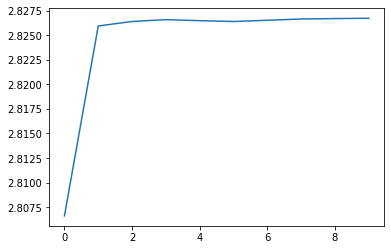

In [46]:
plt.plot(clf.ave_loss_list);

## ストライド

$N_{out} =  \frac{N_{in}+2P-F}{S} + 1$  
$P$: パディングの数  
$F$: フィルタのサイズ  
$S$: ストライドのサイズ  

In [249]:
n_out = (n_in + 2*p - f)/s + 1

NameError: name 'n_in' is not defined

In [164]:
sample0 =np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [1, 2, 3, 4],
                   ])

In [165]:
for k in range(-(3-1), 4):
    print(np.trace(sample0, k))

1
7
10
13
11
4


In [150]:
sample1 =np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [1, 2, 3, 4],
                   [5, 6, 7, 8]])